# <center> SIAM CSE Poster: Param Distribution Part

**Requires:**
* `pymc3` for the hierarchical bayes modeling

In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as sps
from scipy.integrate import quad

import matplotlib.pyplot as plt
%matplotlib inline

Generate data from a `double_tent` pdf.

In [127]:
class double_tent:
    ''' double_tent defines a pdf class object on 0,1 with two triangular peaks
        loc: defines the location of two peaks
        weight: defines the height of peaks. Two hieghts must sum to 1.
        Requires: scipy.stats.trapz
    '''
    
    def __init__(self,loc,weight):
        # check that locations and weights are appropriate
        if loc[0]<0 or loc[0]>1:
            raise ValueError('Peaks must be in [0,1]')
        elif loc[1]<0 or loc[1]>1:
            raise ValueError('Peaks must be in [0,1]')
        
        if weight[0]+weight[1]!=1:
            raise ValueError('Weights must sum to 1')
        
        self.loc = loc # defines two peaks of pdf
        self.weight = weight # defines two heights of pdf
        
        # defines pdf function
        self.pdf_fun = lambda x: weight[0]*sps.trapz.pdf(x,loc[0],loc[0],loc=0,scale=0.385)+ \
                        weight[1]*sps.trapz.pdf(x,loc[1],loc[1],loc=0.8,scale=0.2)
    
    
    def pdf(self,x):
        return self.pdf_fun(x)
    
    def rvs(self,N):
        '''Generates N samples from the pdf'''
        # accept reject for sample from f
        sample = np.ones(N)*np.NaN
        i=0 # index for while loop

        while i<N:
            test = np.random.uniform(0,1) # test value

            # acceptance criteria
            if np.random.uniform(0,1)<self.pdf(test)/4:
                sample[i]=test
                i+=1

        return sample
    

In [128]:
##### FIXED PARAMETERS - DEFINE YOUR EXPERIMENT #####
start_time = 1
end_time = 3
sigma2 = 1E-3
sigma = np.sqrt(sigma2) # fixed noise level in the data
data_n = 50
sample_size = 800
####

### Generate the Data

We generate data from a double tent function $\lambda$. 

In [140]:
# # define target distribution and noise distribution
# target_alpha = 2
# target_beta = 5

# define the target distribution
lam_dist = double_tent(loc=[0.6,0.2],weight=[0.75,0.25])
noise_dist = sps.norm(0,sigma)

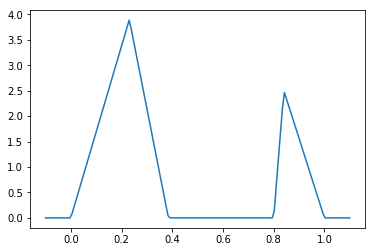

In [141]:
np.linspace(-0.1,1.1,100)
plt.plot(x,lam_dist.pdf(x))

The $Q$ map is:

\begin{align}
Q(\lambda,\delta)=0.5\cdot \exp(-\lambda t)+\delta
\end{align}

where we assume $t=0.5$ is constant and $\delta$ is a random variable representing a noise parameter.

In [142]:
# defines the map from parameters to data
def data_map(param,t=np.array([2])):
    q_map = 0.5*np.exp(-t*param)
    noise = noise_dist.rvs(size=q_map.shape)
    q_out = q_map+noise
    return q_out, (q_map,noise)

In [143]:
# gets a sample of lambda for the observed data
lam_sample = lam_dist.rvs(data_n)
data_sample, (this_q,this_noise) = data_map(lam_sample)

(array([ 2.,  5.,  1.,  0.,  1.,  6.,  8., 11., 10.,  6.]),
 array([0.01486988, 0.0576077 , 0.10034552, 0.14308334, 0.18582116,
        0.22855898, 0.2712968 , 0.31403462, 0.35677244, 0.39951026,
        0.44224808]),
 <a list of 10 Patch objects>)

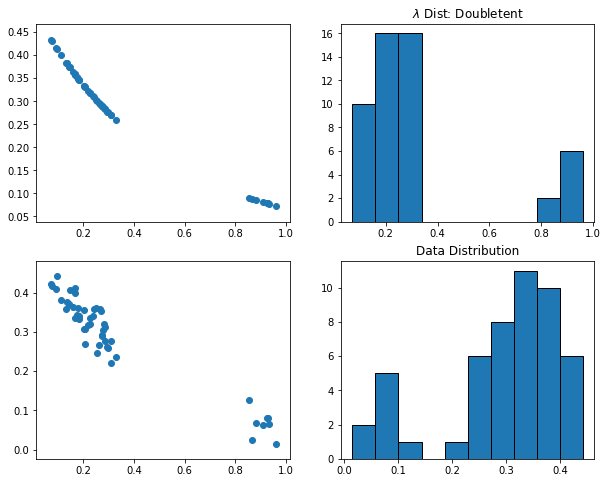

In [144]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(2,2,1)
ax.scatter(lam_sample,this_q)

ax = fig.add_subplot(2,2,2)
ax.set_title('$\lambda$ Dist: Doubletent')
ax.hist(lam_sample,edgecolor='k')

ax = fig.add_subplot(2,2,3)
ax.scatter(lam_sample,data_sample)

ax = fig.add_subplot(2,2,4)
ax.set_title('Data Distribution')
ax.hist(data_sample,edgecolor='k')

# Infer Using Hierarchical Parameteric Bayes

Here we use the following parametric Bayesian model:

\begin{align}
\alpha,\beta\ &\sim  U[0,10] \\
\lambda\ \mid\ \alpha,\beta &\sim \text{beta_distr}(\alpha,\beta) \\
d\ \mid \ \lambda, (\alpha,\beta) &\sim N(Q(\lambda),\sigma^2)
\end{align}

In [163]:
with pm.Model() as model:
    ab = pm.Uniform('hyper',lower=0,upper=10,shape=(2,))
    lam = pm.Beta('lambda',alpha=ab[0],beta=ab[1], shape=data_n)
    Q_map = pm.Deterministic('Q',0.5*pm.math.exp(-2*lam))
    dat = pm.Normal('data',mu=Q_map,sigma=sigma,observed=data_sample)
    trace = pm.sample(1500,tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda, hyper]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 4000/4000 [00:11<00:00, 350.17draws/s]


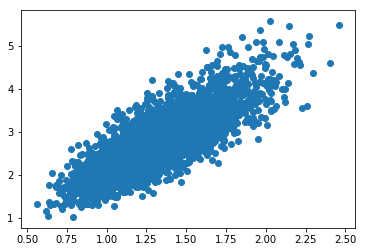

In [164]:
plt.scatter(trace['hyper'][:,0],trace['hyper'][:,1])

In [165]:
bayes_sol = np.average(trace['hyper'],axis=0)
print(bayes_sol)

[1.31749807 2.74323361]


In [148]:
?lam_dist

In [166]:
lam_init = sps.beta(a=1,b=1)

In [167]:
lam_init_sample = lam_init.rvs(1000)
pf_init_sample, z = data_map(lam_init_sample)

data_dist = sps.gaussian_kde(data_sample)
pf_dist = sps.gaussian_kde(pf_init_sample)

In [168]:
def f(x):
    y = np.zeros_like(x)
    non_zeros = np.logical_and(x!=0,-0.5*np.log(2*x)>0,-0.5*np.log(2*x)<1)
    print(non_zeros.shape)
    y[non_zeros] = 1/(2*x[non_zeros])
    return y


In [169]:
# exact data distribution
def exact_q_distr(x):
    y = np.zeros_like(x)
    q_inv = -0.5*np.log(2*x)
    non_zeros = np.logical_and(x!=0,q_inv>0,q_inv<1)
    y[non_zeros] = lam_dist.pdf(q_inv[non_zeros])*1/(2*x[non_zeros])
    return y


In [170]:
y = 0.5*np.exp(-2*lam_dist.rvs(1000))

(array([0.93593919, 2.33984797, 0.46796959, 0.        , 0.46796959,
        2.80781756, 3.74375675, 5.14766552, 4.67969593, 2.80781756]),
 array([0.01486988, 0.0576077 , 0.10034552, 0.14308334, 0.18582116,
        0.22855898, 0.2712968 , 0.31403462, 0.35677244, 0.39951026,
        0.44224808]),
 <a list of 10 Patch objects>)

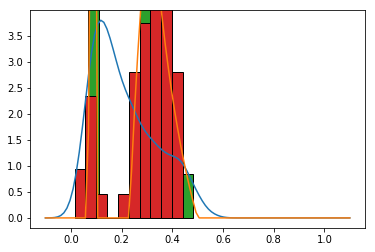

In [171]:
x = np.linspace(-0.1,1.1,100)
plt.plot(x,pf_dist(x))
plt.autoscale(False)
plt.plot(x,exact_q_distr(x))
plt.hist(y,density=True,edgecolor='k')
plt.hist(data_sample,density=True,edgecolor='k')

In [172]:
pf_dist(pf_init_sample[0:100]).shape

(100,)

In [173]:
# accept-reject algorithm
# calculate maximum of the ratio
M = np.max(data_dist(pf_init_sample)/pf_dist(pf_init_sample))

# generate random numbers from uniform for accept-reject for each sample value
test_value = np.random.uniform(0,1,np.shape(pf_init_sample))

# calculate the ratio for accept reject: data_kde/push_kde/M and compare to test sample
# is the kde ratio > test value?
accept_or_reject_samples = np.greater(data_dist(pf_init_sample)/pf_dist(pf_init_sample)/M,
                            test_value)

# accepted values of posterior sample
updated_sample = lam_init_sample[accept_or_reject_samples]

print(np.shape(updated_sample))

(315,)


In [174]:
updated_dist = sps.gaussian_kde(updated_sample)

In [175]:
len(trace['lambda'].reshape(-1,))

150000

In [176]:
# solve polynomial
update_var = np.var(updated_sample)
update_mean = np.mean(updated_sample)
print(update_mean, update_var)

M = (1-update_mean)/update_mean
K = update_var*(1+update_mean)**2

update_alpha = (M/(update_var*(1+M)**2)-1)/(1+M)
update_beta = M*update_alpha
print(update_alpha)
print(update_beta)

0.3038845179981584 0.05797303586403572
0.804964454872729
1.8439511930037689


In [177]:
print(update_alpha/(update_alpha+update_beta))
#print(M*update_alpha**2-K*update_alpha**2*(update_alpha*(1+M)+1))
print(update_alpha*update_beta-update_var*(update_alpha+update_beta)**2*(update_alpha+update_beta+1))
print(update_alpha*update_beta/((update_alpha+update_beta)**2*(update_alpha+update_beta+1)))

0.3038845179981584
0.0
0.05797303586403572


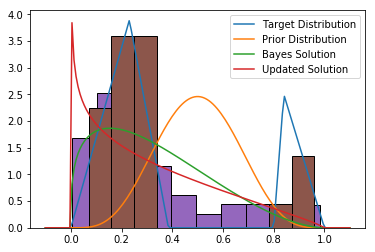

In [178]:
x = np.linspace(-0.1,1.1,150)

plt.figure()

plt.plot(x,lam_dist.pdf(x),label='Target Distribution')
plt.plot(x,sps.beta.pdf(x,a=5,b=5),label='Prior Distribution')
plt.plot(x,sps.beta.pdf(x,a=bayes_sol[0],b=bayes_sol[1]),label='Bayes Solution')
plt.plot(x,sps.beta.pdf(x,a=update_alpha,b=update_beta),label='Updated Solution')
#plt.plot(x,updated_dist(x),label='Updated Solution')
plt.hist(updated_sample,density=True,edgecolor='k')
#plt.hist(trace['lambda'].reshape(-1,),density=True,edgecolor='k',alpha=0.4)
plt.hist(lam_sample,density=True,edgecolor='k')
plt.legend()

(array([  3.,  27., 117., 232., 331., 397., 290., 137.,  57.,   9.]),
 array([0.27325738, 0.27913059, 0.28500379, 0.290877  , 0.29675021,
        0.30262341, 0.30849662, 0.31436983, 0.32024303, 0.32611624,
        0.33198944]),
 <a list of 10 Patch objects>)

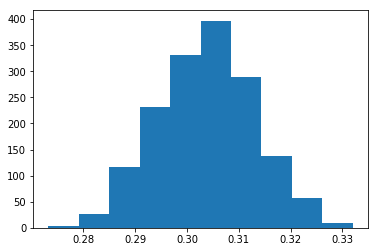

In [162]:
plt.hist(np.average(trace['lambda'],axis=1))

In [86]:
np.min(trace['data'])

-0.05977339253064766

In [132]:
np.average(trace['lambda'])

0.2624522310422296

(array([ 1.1854734 ,  7.79025375, 23.20140792, 58.08819647, 71.12840384,
        65.70909688, 33.70131515,  7.79025375,  2.20159345,  0.16935334]),
 array([0.24536313, 0.24905364, 0.25274415, 0.25643466, 0.26012517,
        0.26381567, 0.26750618, 0.27119669, 0.2748872 , 0.27857771,
        0.28226822]),
 <a list of 10 Patch objects>)

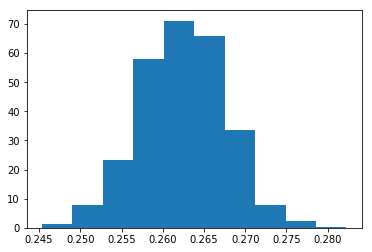

In [131]:
plt.hist(trace['lambda'],density=True)

(array([ 18.,  76., 151., 305., 371., 334., 206., 102.,  28.,   9.]),
 array([-0.14379222, -0.11351517, -0.08323812, -0.05296106, -0.02268401,
         0.00759304,  0.0378701 ,  0.06814715,  0.0984242 ,  0.12870126,
         0.15897831]),
 <a list of 10 Patch objects>)

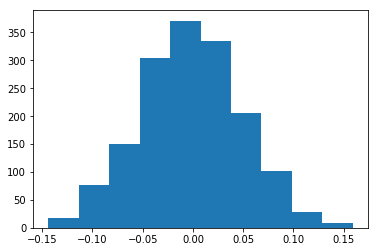

In [84]:
plt.hist(trace['data']-trace['Q'])

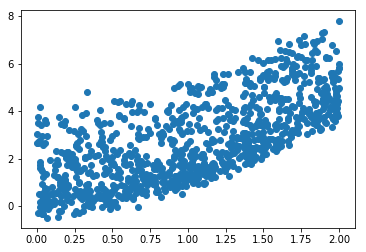

In [70]:
plt.scatter(trace['data'][:,1],trace['data'])

In [42]:
z = b.random(size=1000)
print(z.shape)

(1000, 2)


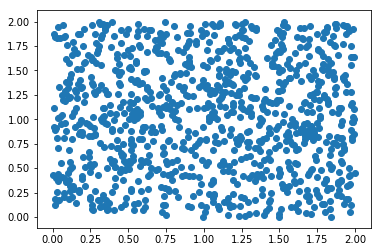

In [40]:
plt.scatter(z[:,:,0],z[:,:,1])

In [3]:

# rat data (BDA3, p. 102)
y = np.array([
    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
    1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  5,  2,
    5,  3,  2,  7,  7,  3,  3,  2,  9, 10,  4,  4,  4,  4,  4,  4,  4,
    10,  4,  4,  4,  5, 11, 12,  5,  5,  6,  5,  6,  6,  6,  6, 16, 15,
    15,  9,  4
])
n = np.array([
    20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20,
    20, 19, 19, 18, 18, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49, 19,
    46, 27, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20,
    48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46,
    47, 24, 14
])

N = len(n)



In [5]:
def logp_ab(value):
    ''' prior density'''
    return tt.log(tt.pow(tt.sum(value), -5/2))

with pm.Model() as model:
    # Uninformative prior for alpha and beta
    ab = pm.HalfFlat('ab',
                     shape=2,
                     testval=np.asarray([1., 1.]))
    pm.Potential('p(a, b)', logp_ab(ab))

    X = pm.Deterministic('X', tt.log(ab[0]/ab[1]))
    Z = pm.Deterministic('Z', tt.log(tt.sum(ab)))

    theta = pm.Beta('theta', alpha=ab[0], beta=ab[1], shape=N)

    p = pm.Binomial('y', p=theta, observed=y, n=n)
    trace = pm.sample(1000, tune=2000, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, ab]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 6000/6000 [00:34<00:00, 171.61draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [20]:
from matplotlib import pyplot as plt
%matplotlib inline

(array([ 225.,  865.,  555.,  243.,   67.,   31.,    6.,    4.,    3.,    1.]),
 array([  4.20448587,   9.19943194,  14.194378  ,  19.18932407,
         24.18427014,  29.17921621,  34.17416228,  39.16910835,
         44.16405442,  49.15900048,  54.15394655]),
 <a list of 10 Patch objects>)

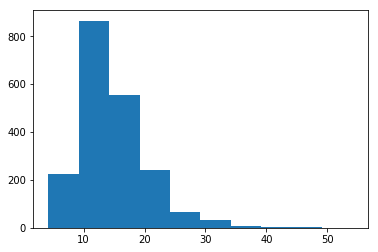

In [22]:
plt.hist(trace['ab'][:,1])

In [26]:
print(np.mean(trace['ab'],axis=0))
print(np.var(trace['ab'],axis=0))


[  2.47397809  14.74903663]
[  0.86392644  30.76525082]


In [4]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    obs = pm.Normal('obs', mu=mu, sigma=1, observed=np.random.randn(100))

In [7]:
model.logp({'mu': 0})

array(-148.19248227775765)

In [2]:
import numpy as np
import scipy.stats as ss
from cbayes import sample, solve, distributions
import ipywidgets as wd
from matplotlib import pyplot as plt

In [3]:
plt.rcParams.update({'font.size': 42})
plt.rcParams['figure.figsize'] = 20, 20
from mpl_toolkits.mplot3d import Axes3D


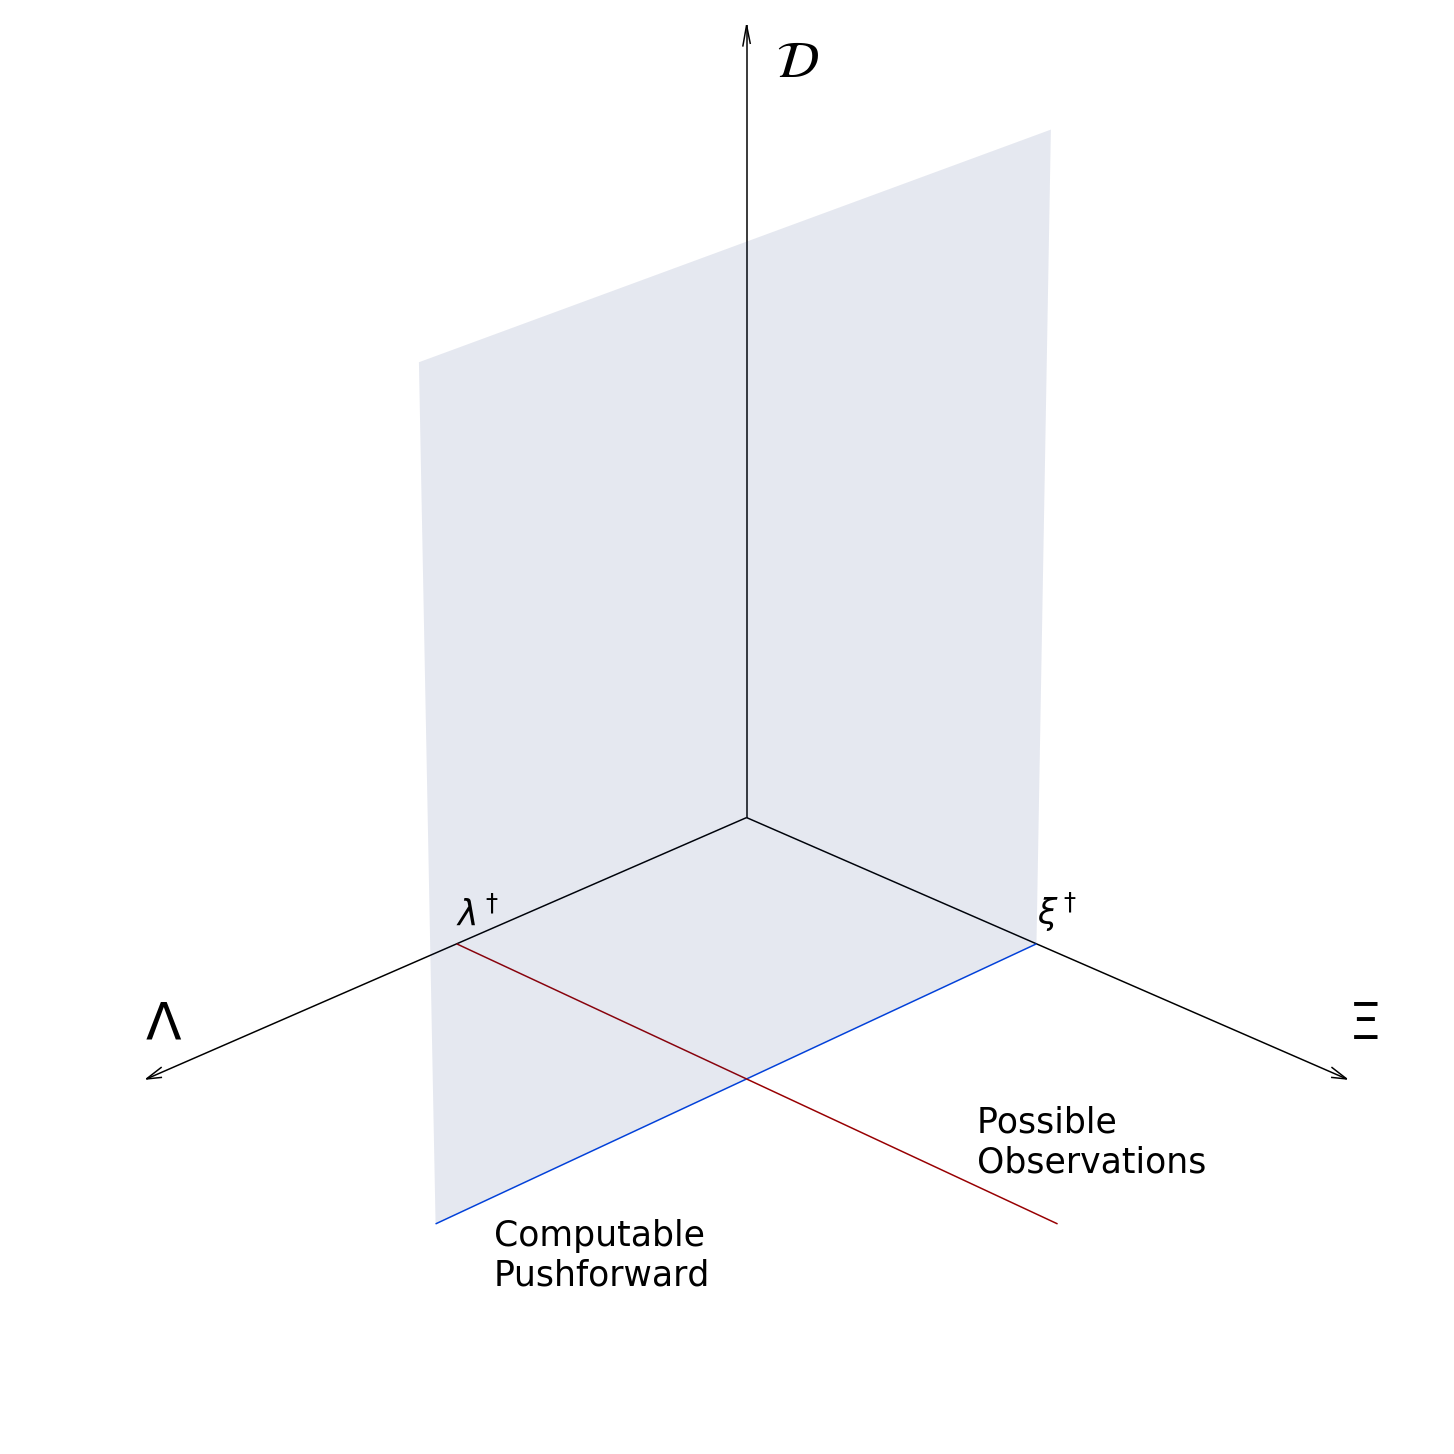

In [3]:
fig3d = plt.figure()
ax = fig3d.add_subplot(111, projection='3d')

# xx, zz = np.meshgrid(np.linspace(0,1,10), np.linspace(0,1,10))
# point = np.array([0.5, 0.5, 0.5])
# normal = np.array([0, 1, 0])
# d = -point.dot(normal)
# y = (-normal[0] * xx - normal[1] * zz - d)*1./normal[1]
# ax.plot_surface(xx, yy, z, alpha=0.2)

ax = plt.subplot(projection='3d')
ax.grid(False)
ax.axis('off')
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])


fsize=52
ax.text(1,0,0.05, '$\\Lambda$', fontsize=fsize)
ax.text(0.5,0,0.025,'$\\lambda^\dagger$', fontsize=fsize/1.5)

ax.text(0,1,0.05, '$\\Xi$', fontsize=fsize)
ax.text(0,0.5,0.025,'$\\xi^\dagger$', fontsize=fsize/1.5)

ax.text(0,0.05,0.95, '$\\mathcal{D}$', fontsize=fsize)

x, y, z = np.zeros((3,3))
u, v, w = np.array([[1,0,0],[0,1,0],[0,0,1]])
ax.quiver(x,y,z,u,v,w,arrow_length_ratio=0.025, color='black')

xx, zz = np.meshgrid(range(2), range(2))
ax.plot_surface(xx, zz*0 + 0.5, zz, alpha = 0.10, color='xkcd:blue')
ax.quiver(0,0.5,0, 1,0,0, arrow_length_ratio=0, color='xkcd:blue')

ax.text(0.475,0.85,0, "Possible\nObservations", fontsize=fsize/1.5)
ax.text(1.05,0.65,0, "Computable\nPushforward", fontsize=fsize/1.5)
ax.quiver(0.5,0,0, 0,1,0, arrow_length_ratio=0, color='xkcd:blood red')

ax.view_init(25, 45)
ax.set_xlim3d([0,0.9])
ax.set_ylim3d([0,0.9])
ax.set_zlim3d([0,0.85])

plt.tight_layout(pad=0)
plt.savefig('diagram.png')
plt.show()

# <center> Example
## <center> Exponential Decay

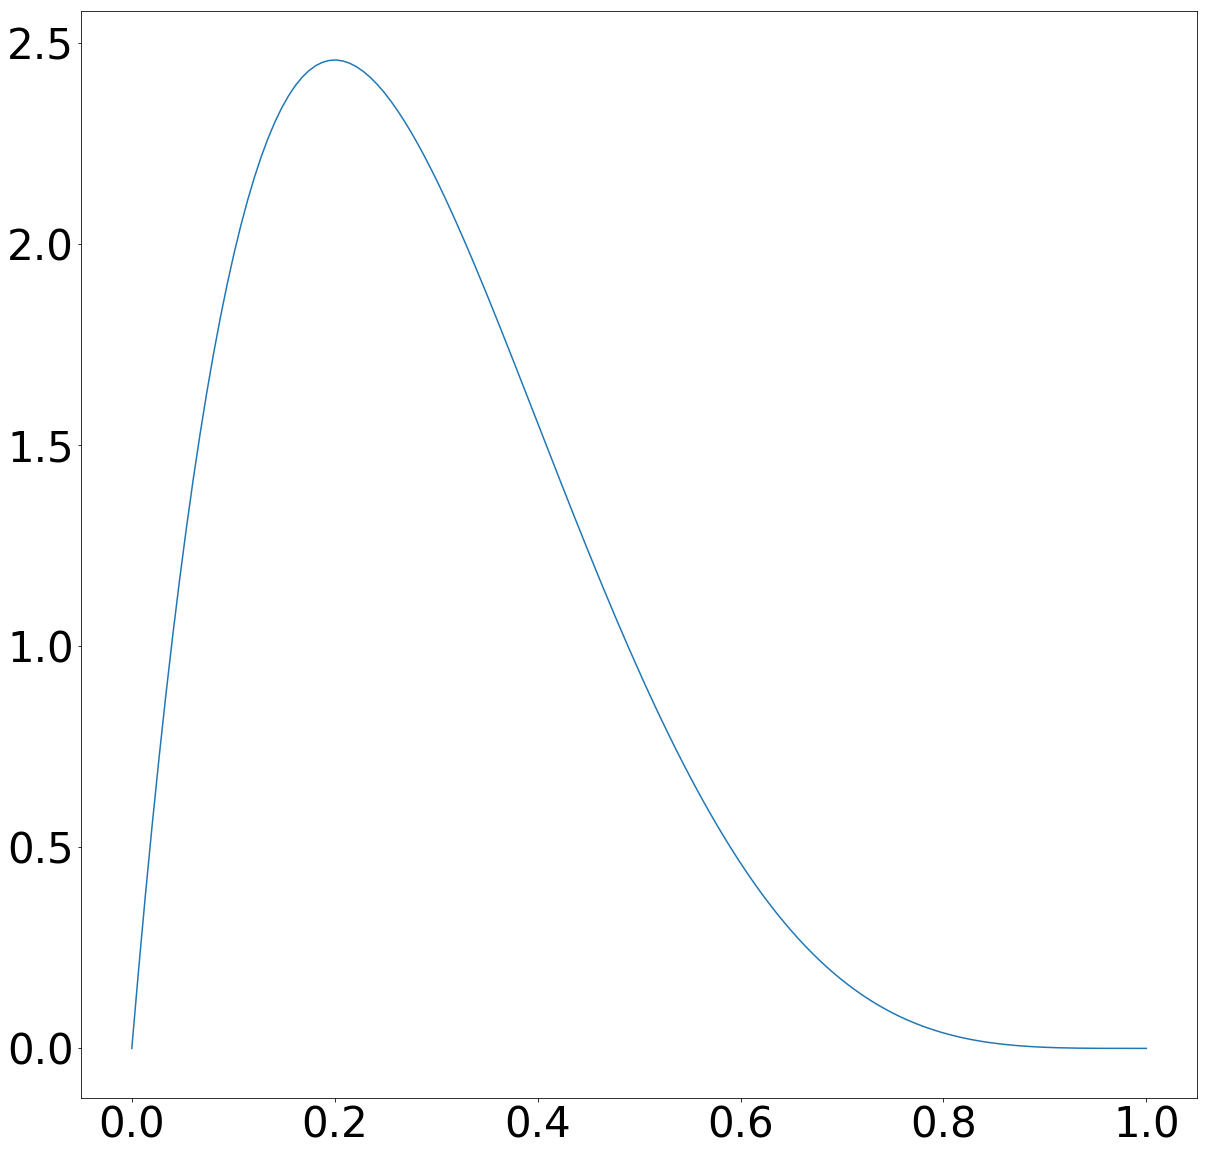

In [4]:
# true distribution
target_dist = ss.beta(2,5)
x = np.linspace(0,1,150)
plt.plot(x,target_dist.pdf(x))
plt.show()

In [5]:
lam_values = 0.5
def makeDecayModel(t):
    def model(lam = np.array([[lam_values]]) ):
        rate = lam[:,0].reshape(-1,1)
        initial_cond = 0.5
        response = initial_cond*np.exp(np.outer(rate, -t))
        if response.shape[0] == 1:
            return response.ravel() # this allows support for simpler 1D plotting.
        else:
            return response
    return model


In [10]:
##### FIXED PARAMETERS - DEFINE YOUR EXPERIMENT #####
start_time = 1
end_time = 3
sigma2 = 1E-3
sigma = np.sqrt(sigma2) # fixed noise level in the data
observed_lam = 100
####

In [64]:
full_time = np.linspace(0, end_time, 1000)
full_model = makeDecayModel(full_time)
sampled_response = full_model(target_dist.rvs(size=[observed_lam,1])) # here we pass the number of observed lambda values
average_response = np.average(sampled_response,axis=0) # average response for 100 lambda values
sample_sigma = np.sqrt(np.var(sampled_response,axis=0)) # noise level of the data at each times step

In [93]:
print(sampled_response.shape)
n_rand_scatters = 100
random_lam_idx = np.random.randint(0,sampled_response.shape[0],n_rand_scatters)
random_time_idx = np.random.randint(0,sampled_response.shape[1],n_rand_scatters)

#sampled_response[random_lam_idx,random_time_idx]

(100, 1000)


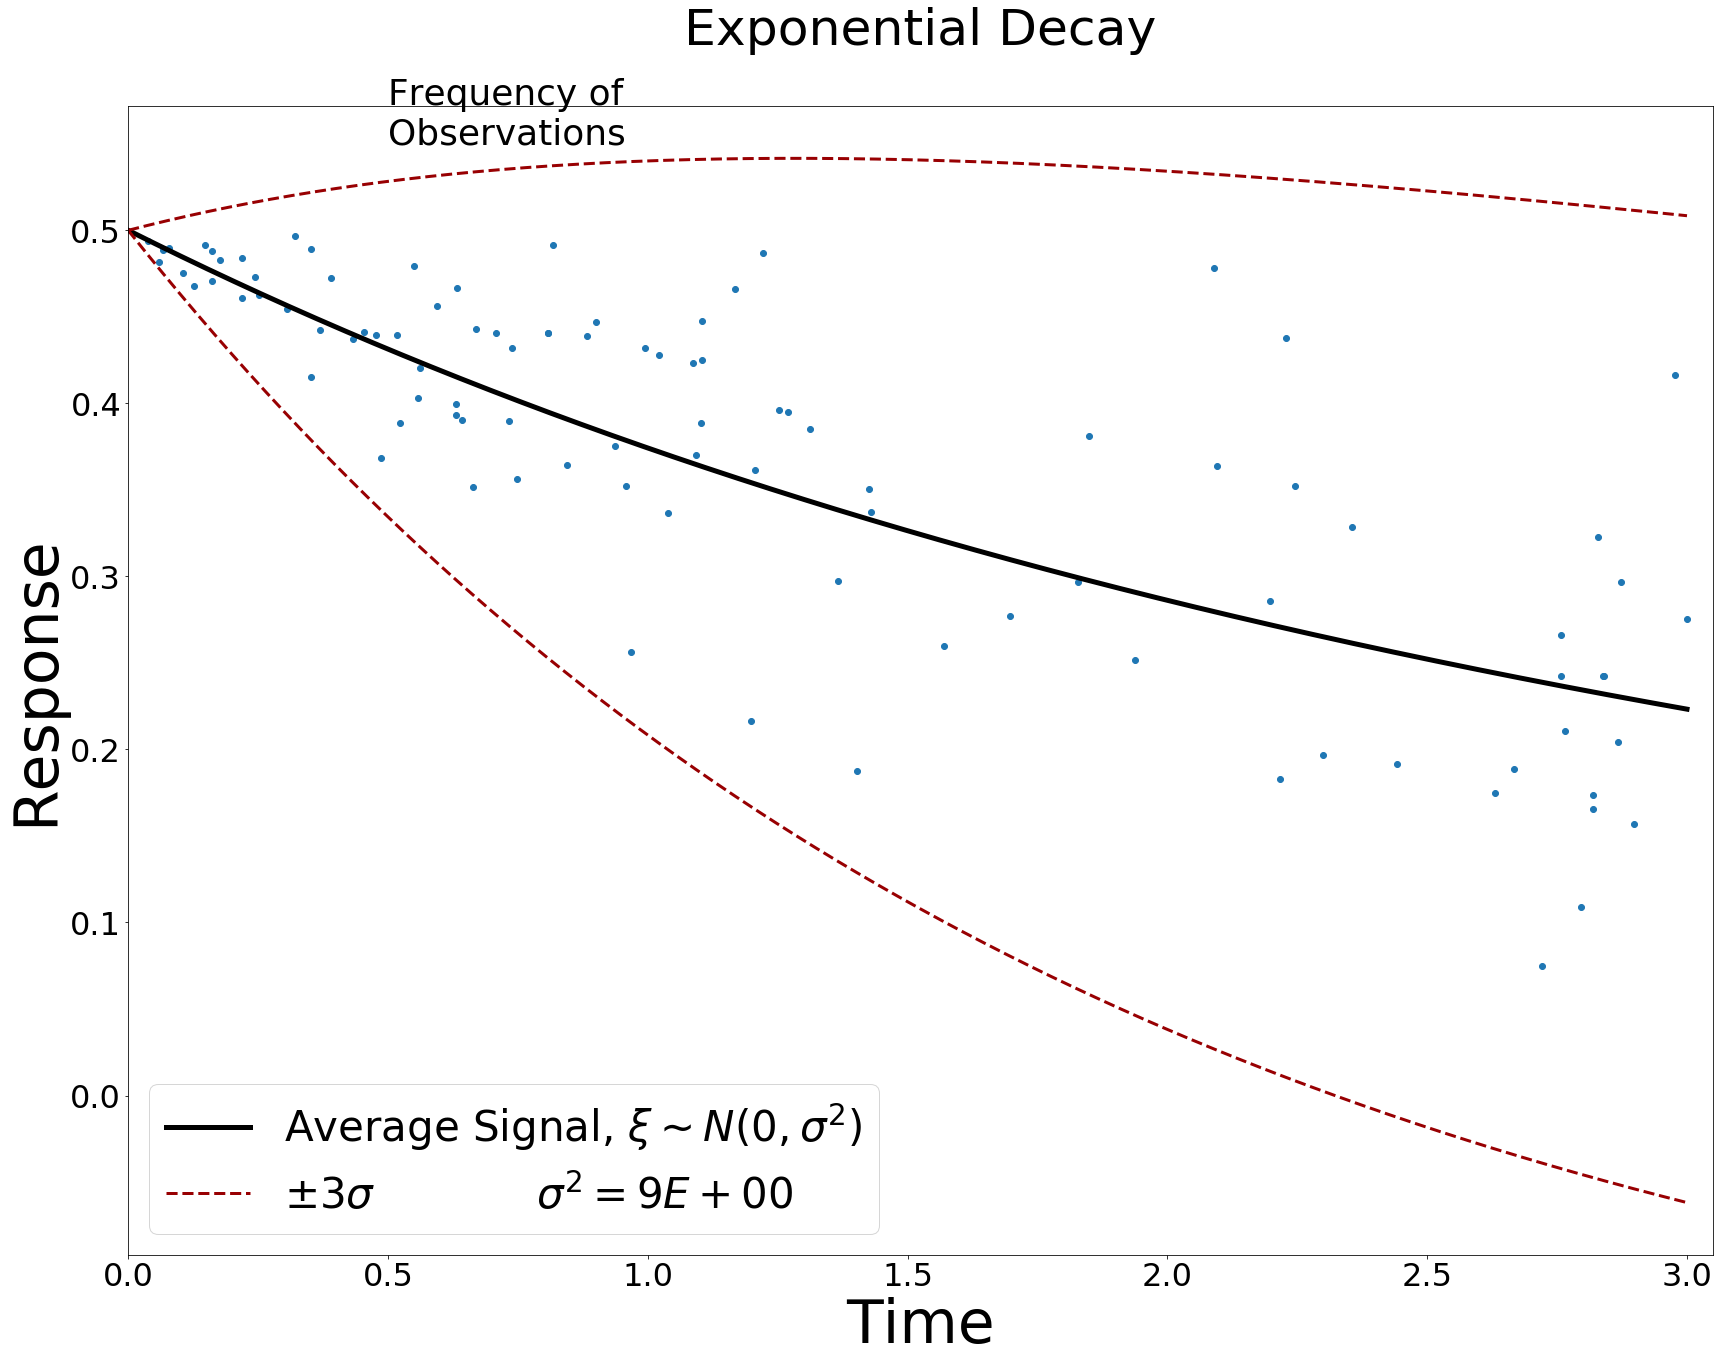

In [95]:
filename = 'exponential_decay_response' + '_sigma-%dE-4'%(sigma2*10000) + '.png'
plt.rcParams['figure.figsize'] = 25, 20
fig = plt.figure()


plt.plot(full_time, average_response, lw=5, c='k', alpha=1, 
         label="Average Signal, $\\xi \\sim N(0, \\sigma^2)$")
plt.title("Exponential Decay\n")
plt.plot(full_time, average_response+3*sample_sigma, ls='--', lw=3, c='xkcd:blood red', alpha=1)
plt.plot(full_time, average_response-3*sample_sigma, ls='--', lw=3, c='xkcd:blood red', alpha=1, 
         label="$\\pm3\\sigma \qquad\qquad \\sigma^2=%1.0E$"%(3**2))

# SET GLOBAL STYLES
marker_list = ['o', 'o', 'o', 'o']
marker_size = [50, 100, 150, 200]
colors = ['xkcd:neon pink', 'xkcd:forest green', 'xkcd:orange', 'xkcd:blue']
colors = colors[::-1]


plt.scatter(full_time[random_time_idx],sampled_response[random_lam_idx,random_time_idx])
# t = np.linspace(start_time, end_time, 100)
# model = makeDecayModel(t)
# np.random.seed(11)
# u = model() + np.random.randn(100)*sigma

# for idx, num_obs in enumerate([1, 2, 10, 100]):
#     col = colors[idx]
#     start_ticks = 0.65
#     tick_width = 0.025
#     plt.vlines(t[0:100:(num_obs)], start_ticks-idx/20, start_ticks+tick_width-idx/20, color=col, lw=3)
#     plt.scatter(t[0:100:(num_obs)], u[0:100:(num_obs)], color=col, marker='.', s=250, alpha=1)#, label="Data for $D=%d$"%(100/num_obs))
# plt.scatter(t, u, color='xkcd:blood red', s=250, alpha=0.75, marker='.')
# plt.scatter(t[0:100:10], u[0:100:10], color='xkcd:red', s=100, alpha=0.75, marker='.')
plt.annotate("Frequency of\nObservations",[0.5,0.55], fontsize=36)
#plt.ylim([0,1])
plt.xlim([0,end_time+.05])
plt.ylabel('Response', fontsize=60)
plt.xlabel('Time', fontsize=60)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.legend()
plt.tight_layout()
#plt.savefig(filename)
plt.show()

## Generate Simulated Data

In [23]:
sample_size = 500
t = np.array([2])
data_model = makeDecayModel(t)
u = data_model(target_dist.rvs(size=[sample_size,1])) + ss.norm.rvs(0,sigma, size=[sample_size,1])


In [24]:
data_model(target_dist.rvs(size=[sample_size,1])).shape

(500, 1)

In [28]:
plt.hist(u.reshape(-1,))
#plt.show()

(array([ 16.,  37.,  56.,  69.,  95.,  87.,  66.,  47.,  17.,  10.]),
 array([ 0.0906955 ,  0.13506329,  0.17943109,  0.22379888,  0.26816667,
         0.31253447,  0.35690226,  0.40127005,  0.44563784,  0.49000564,
         0.53437343]),
 <a list of 10 Patch objects>)

## Test the computation of a forward hierarchical bayes method

\begin{align}
a,b &\sim U[0,10]\times U[0,10] \\
\lambda\mid a,b &\sim \beta(a,b) \\
d \mid \lambda, a,b &\sim N(Q(\lambda,t),\sigma^2)
\end{align}

where $\sigma^2$ is known, $Q(\lambda,t)$ is the map from $\Lambda\rightarrow\mathcal{D}$.

In [7]:
# define the hyper parameter distribution
a_hyper_dist = ss.uniform(0,10)
b_hyper_dist = ss.uniform(0,10)


In [8]:
x = a_hyper_dist.rvs(1000)
y = b_hyper_dist.rvs(1000)

# plt.scatter(x,y)
# plt.show()

In [9]:
sample_hyper_params = (x,y)



In [32]:
def data_likelihood( q_values, data = u):
    

D = distributions.parametric_dist(sample_size)
for i in range(sample_size):
    D.assign_dist('norm', kwds={'loc': u[i], 'scale': sigma})
#     output_samples = model(input_samples)
#     outs = output_samples[:,:num_obs]
#     evidence = scipy.integrate.quad(lambda x: D.pdf(model(x)[:num_obs].reshape(1,-1)),
#                                     -1, 1)[0]
#     likelihood = D.pdf(outs)
#     asr = np.argsort(input_samples[:,0])
#     sorted_inputs = input_samples[asr]
#     sorted_outputs = likelihood[asr]*in_dist.pdf(input_samples)[asr]
#     ax.plot(sorted_inputs, sorted_outputs/evidence, alpha = 0.2, 
#             label="$D=%d$"%num_obs, c= colors[3-idx], lw=5)

In [33]:
D.pdf(np.linspace(-1,1,10))

IndexError: Could not infer dimensions. `eval_points` has the wrong shape.

In [ ]:

def makeBayesDistr(t):
    def model(lam = np.array([[lam_values]]) ):
        rate = lam[:,0].reshape(-1,1)
        initial_cond = 0.5
        response = initial_cond*np.exp(np.outer(rate, -t))
        if response.shape[0] == 1:
            return response.ravel() # this allows support for simpler 1D plotting.
        else:
            return response
    return model

lam_distr = ss.beta()

In [8]:
!mv exponential_decay_response*.png ../../poster_cse/

mv: cannot move 'exponential_decay_response_sigma-10E-4.png' to '../../poster_cse/': Not a directory


## Define Error Functional(s)

In [9]:
def error_function(model, obs_data, sigma=None, ftype='clt'):   # this generates a sum of squared residuals.
    def QoI_fun(inputs): # that conforms to our desired model input
        D = len(obs_data)
        predictions = model(inputs)
        assert predictions.shape[1] == D
        residuals = predictions - obs_data
        if ftype is 'clt':
            QoI = np.sqrt(1./D)*np.sum( residuals/sigma, axis=1 )  # CLT
        elif ftype is 'mse':
            if sigma is not None:
                QoI = (1./D)*np.sum( (residuals/sigma)**2, axis=1 )   # MSE
            else:
                QoI = (1./D)*np.sum( (residuals/obs_data)**2, axis=1 )  # MRSE
        elif ftype is 'sse':
            QoI = np.sum( (residuals/sigma)**2, axis=1 )  # SSR
        return QoI
    
    return QoI_fun

# <center> Convergence

In [10]:
num_samples = N = int(1E3) # number of input samples (N)
err_fun_type = 'clt'
input_dim = 1

# lam_mesh = np.linspace(0,1,1000).reshape(-1,1)
lam_mesh = np.linspace(0.4, 0.6, 500).reshape(-1,1)

np.random.seed(21)

s_set = sample.sample_set(size=(num_samples, input_dim))
# DEFINE DISTRIBUTIONS
s_set.set_dist('beta', kwds={'a': 1, 'b': 1, 'loc': 0, 'scale': 1}, dim=0) # initial condition
# s_set.set_dist('norm', kwds={'loc': 0, 'scale': sigma}, dim=1) # noise
s_set.generate_samples()
input_samples = s_set.samples # create a pointer for ease of reference later with plotting.
in_dist = s_set.dist
in_pdf = in_dist.pdf(lam_mesh)

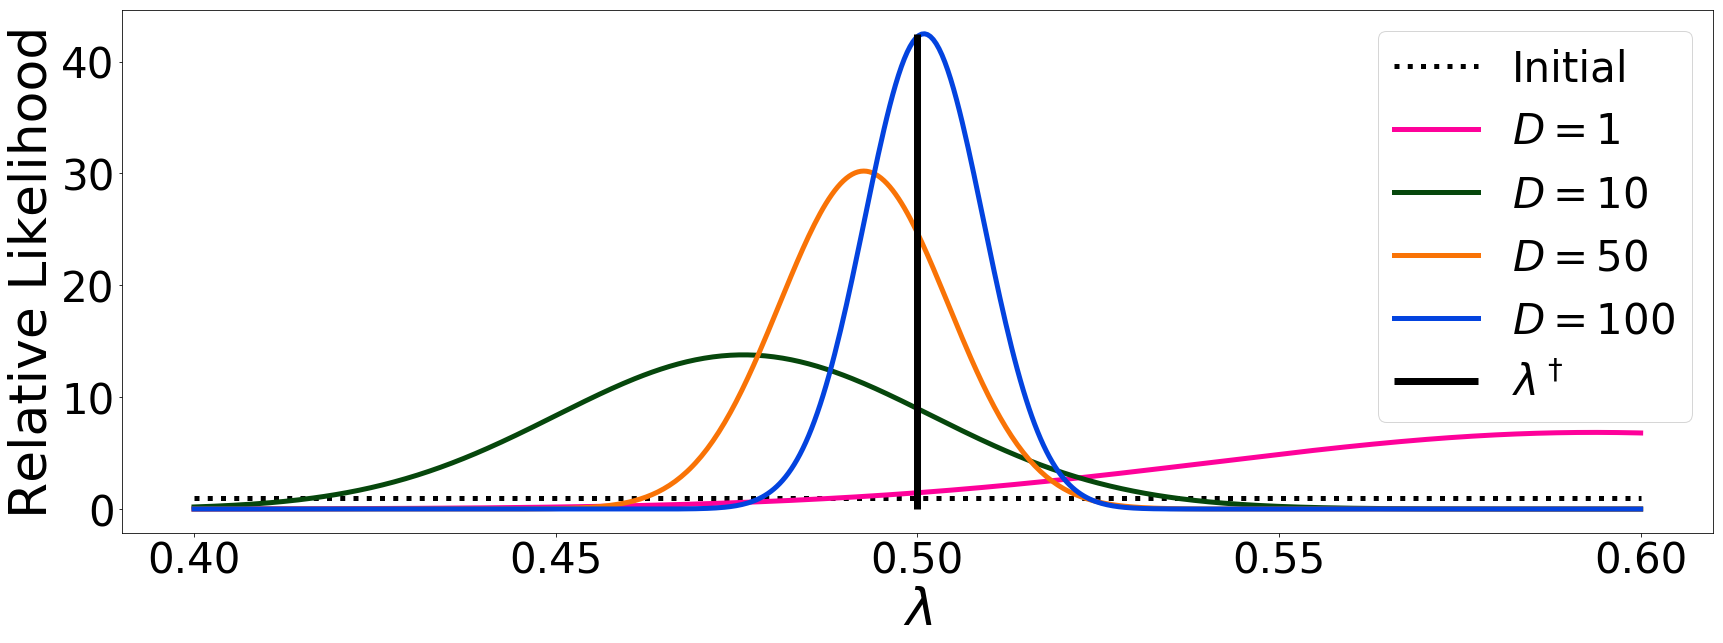

In [11]:
np.random.seed(11)
plt.rcParams['figure.figsize'] = 25, 10
fig = plt.figure()
ax = plt.gca()
ax.plot(lam_mesh, in_pdf, label="Initial", color='xkcd:black', ls=':', lw=5)
noise_vector = np.random.randn(int(100))*sigma

for idx,num_observations in enumerate([1,10,50,100]):
    
    t = np.linspace(start_time, end_time, num_observations)
    exponential_decay_model = makeDecayModel(t)
    u_true = exponential_decay_model() # evaluate model at truth


    observed_data = u_true + noise_vector[0:num_observations]
    QoI_fun = error_function(exponential_decay_model, observed_data, sigma=sigma, ftype=err_fun_type)

    p_set = sample.map_samples_and_create_problem(s_set, QoI_fun)
    output_samples = p_set.output.samples # handle for convenience

    ## Compute Predicted Distribution
    # (The Predicted Measure is the push-forward of the Initial Measure under the map $Q$)
    p_set.compute_pushforward_dist()
    pr_dist = p_set.pushforward_dist # handle for convenience

    ## Pick Appropriate Observed Distribution
    if err_fun_type is 'clt':
        p_set.set_observed_dist('normal', {'loc': 0, 'scale': 1}, dim=0)
    elif err_fun_type is 'mse':
        p_set.set_observed_dist('gamma', {'a':num_observations/2, 'scale':2/num_observations}, dim=0)
    elif err_fun is 'sse':
        p_set.set_observed_dist('chi2', {'df':num_observations}, dim=0)

    ob_dist = p_set.observed_dist # this is define a pointer for ease of reference.

    ## Solve Problem
    p_set.set_ratio()
    eta_r = p_set.ratio
#     s_set.seed = 11
#     solve.problem(p_set)


    post_eval = p_set.evaluate_posterior(lam_mesh)
    in_pdf = in_dist.pdf(lam_mesh)

    ax.plot(lam_mesh, post_eval, label="$D=%d$"%num_observations, color=colors[3-idx], lw=5)

ax.vlines(0.5, 0, np.max(post_eval), label="$\\lambda^\dagger$", lw=7, alpha=1, zorder=3)
plt.xlabel("$\\lambda$", fontsize=52)
plt.ylabel("Relative Likelihood", fontsize=52)
# plt.xlim([0.4, 0.6])
# plt.xlim([0.25, 0.75])
# plt.ylim([0,120])
ax.set_xticks([.4, .45, .5, .55, .6])
# ax.set_xticklabels([.4, .45, .5, .55, .6])
plt.legend()
plt.tight_layout()
#plt.savefig('updated_convergence' + '_sigma-%dE-4'%(sigma2*10000) + '.png')
#plt.show()


In [12]:
#!mv updated_convergence*.png ../../poster_cse/

mv: cannot move 'updated_convergence_sigma-10E-4.png' to '../../poster_cse/': Not a directory


# <center> Stability

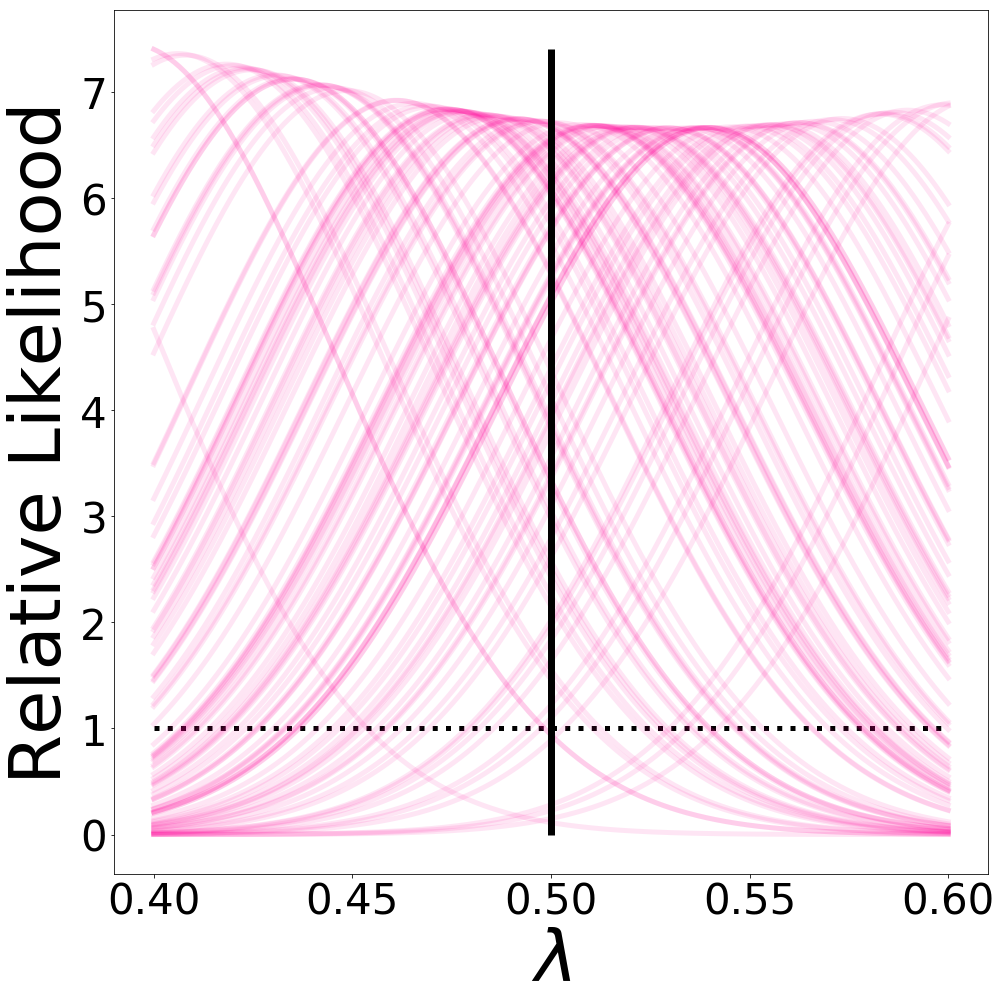

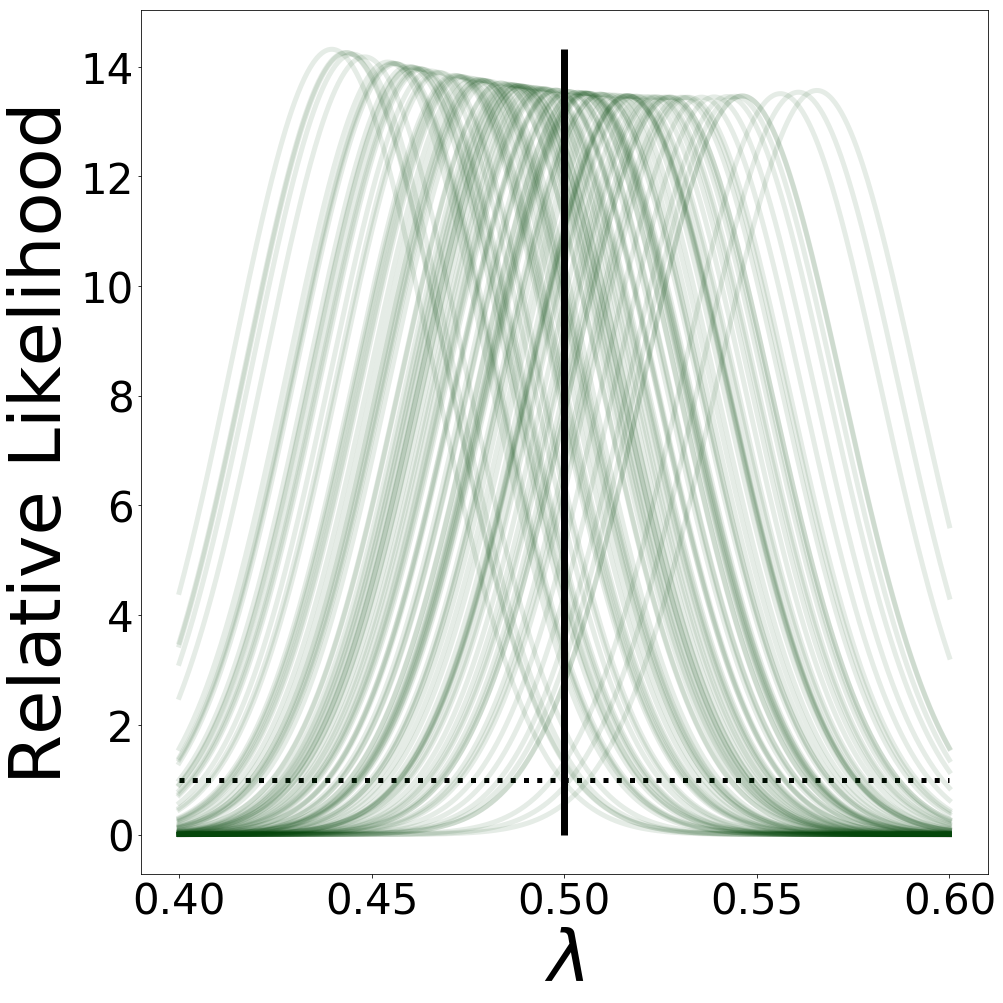

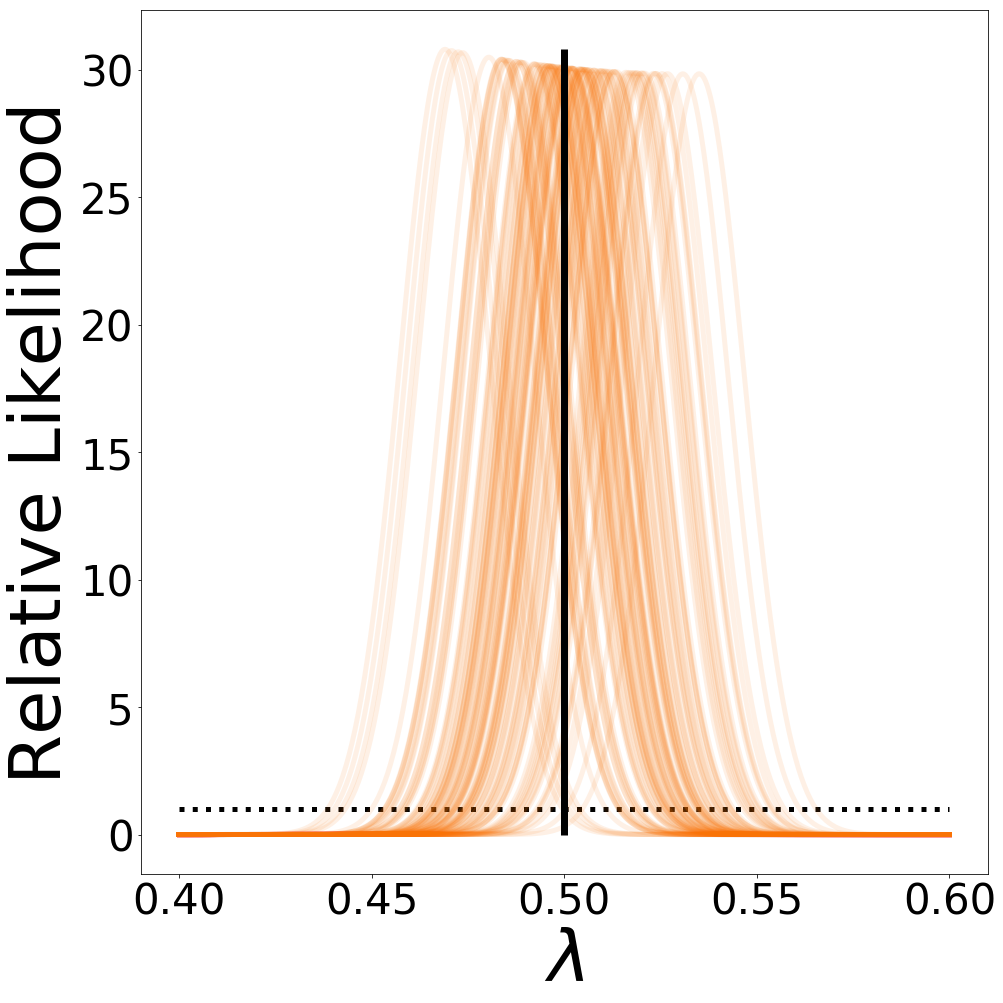

KeyboardInterrupt: 

In [13]:
num_repeats = 100
np.random.seed(21)
plt.rcParams['figure.figsize'] = 15, 15
for idx,num_observations in enumerate([1,10,50,100]):
    fig = plt.figure()
    ax = plt.gca()
    ax.plot(lam_mesh, in_pdf, label="Initial", color='xkcd:black', ls=':', lw=5)
    max_ht = 0
    for i in range(num_repeats):
    #     different noise each time
        noise_vector = np.random.randn(num_observations)*sigma

        t = np.linspace(start_time, end_time, num_observations)
        exponential_decay_model = makeDecayModel(t)
        u_true = exponential_decay_model() # evaluate model at truth


        observed_data = u_true + noise_vector
        QoI_fun = error_function(exponential_decay_model, observed_data, sigma=sigma, ftype=err_fun_type)

        p_set = sample.map_samples_and_create_problem(s_set, QoI_fun)
        output_samples = p_set.output.samples # handle for convenience

        ## Compute Predicted Distribution
        # (The Predicted Measure is the push-forward of the Initial Measure under the map $Q$)
        p_set.compute_pushforward_dist()
        pr_dist = p_set.pushforward_dist # handle for convenience

        ## Pick Appropriate Observed Distribution
        if err_fun_type is 'clt':
            p_set.set_observed_dist('normal', {'loc': 0, 'scale': 1}, dim=0)
        elif err_fun_type is 'mse':
            p_set.set_observed_dist('gamma', {'a':num_observations/2, 'scale':2/num_observations}, dim=0)
        elif err_fun is 'sse':
            p_set.set_observed_dist('chi2', {'df':num_observations}, dim=0)

        ob_dist = p_set.observed_dist # this is define a pointer for ease of reference.

        ## Solve Problem
        p_set.set_ratio()
        eta_r = p_set.ratio


        post_eval = p_set.evaluate_posterior(lam_mesh)
        in_pdf = in_dist.pdf(lam_mesh)
        if i == 0:
            ax.plot(lam_mesh, post_eval, color=colors[3-idx], label='$D=%d$'%num_observations, lw=5, alpha=0.1)
        else:
            ax.plot(lam_mesh, post_eval, color=colors[3-idx], lw=5, alpha=0.1)
        max_ht = np.max([np.max(post_eval), max_ht])

    ax.vlines(0.5, 0, max_ht, label="$\\lambda^\dagger$", lw=7, alpha=1, zorder=3)
    lsize=72
    plt.xlabel("$\\lambda$", fontsize=lsize)
    plt.ylabel("Relative Likelihood", fontsize=lsize)
    # plt.xlim([0.4, 0.6])
    # plt.xlim([0.25, 0.75])
    # plt.ylim([0,120])
#     plt.legend(loc='upper right')
    plt.tight_layout()
#    plt.savefig('updated_stability_D%d'%num_observations + '_sigma-%dE-4'%(sigma2*10000) + '.png')
#    plt.show()
